## EDA of the notation and area .csv files

This notebook performs an exploratory data analysis on the notation and area .csv files contained in the dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import pycountry
import math
from ..src.eda_utils import makeAreaMetadata, areaID

In [2]:
# Read data
notation = pd.read_csv(config.DATA_DIR + 'notation.csv')
areas    = pd.read_csv(config.DATA_DIR + 'areas.csv')

## Area file

According to the [description](https://data.open-power-system-data.org/time_series/), the dataset contains information from various countries in Europe, and for multiple bidding zones within each country. 
The notation.csv file contains some information regarding each column, but additional information is provided on the areas.csv file. Let's have a look at the latter:

In [3]:
areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   area ID                        81 non-null     object
 1   ISO 3166-1 alpha-2             43 non-null     object
 2   MapCode ENTSO-E                70 non-null     object
 3   primary AreaName ENTSO-E       75 non-null     object
 4   primary concept                94 non-null     object
 5   EU memberstate                 94 non-null     bool  
 6   EU inside                      94 non-null     bool  
 7   15min                          84 non-null     object
 8   30min                          84 non-null     object
 9   60min                          84 non-null     object
 10  EIC                            91 non-null     object
 11  meaning cf. ENTSO-E            90 non-null     object
 12  country                        46 non-null     object
 13  bidding

There are areas with missing IDs (around 13):

In [4]:
areas[areas['area ID'].isnull()].iloc[:, -8:]

,load from ENTSO-E TP,generation from ENTSOE-TP,price from ENTSO-E TP,generation from TSO,price from TSO,load from ENTSO-E data portal,load from TSO,Capacity from OPSD
75,False,False,False,False,False,False,False,False
76,False,False,False,False,False,False,False,False
77,False,False,False,False,False,False,False,False
78,False,False,False,False,False,False,False,False
80,False,False,False,False,False,False,False,False
81,False,False,False,False,False,False,False,False
82,False,False,False,False,False,False,False,False
83,False,False,False,False,False,False,False,False
85,False,False,False,False,False,False,False,False
86,False,False,False,False,False,False,False,False


These appear to be dead fields (no spot-prices, and apparently no data). We can drop those, along with the bidding zone aggregation which contains only 4 fields:

In [5]:
areas = areas[~areas['area ID'].isnull()]
areas.drop('bidding zone aggregation', axis = 1, inplace = True)

Check missing data:

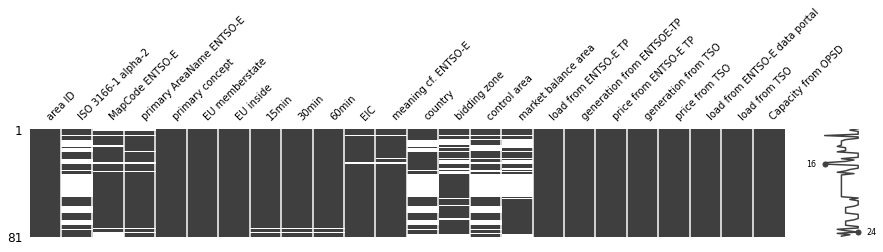

In [6]:
msno.matrix(areas, figsize = (15, 2), fontsize = 10);

There are a lot of missing fields in the country, bidding zone (, etc) fields, but we should be able to infer those from the area ID. Let's check a few samples:

In [7]:
cols = ['area ID', 'country', 'ISO 3166-1 alpha-2', 'MapCode ENTSO-E', 'primary AreaName ENTSO-E', 'bidding zone', 'control area', 'market balance area'] 
areas[cols].head(10)

,area ID,country,ISO 3166-1 alpha-2,MapCode ENTSO-E,primary AreaName ENTSO-E,bidding zone,control area,market balance area
0,AT,Austria,AT,AT,Austria,APG,APG,APG
1,BA,Bosnia Herzegovina,BA,NaN,NaN,NOS BiH,NOS BiH,NOS BiH
2,BE,Belgium,BE,BE,Belgium,Elia,Elia,Elia
3,BG,Bulgaria,BG,BG,Bulgaria,ESO,ESO,ESO
4,CH,Switzerland,CH,CH,Switzerland,swissgrid,swissgrid,swissgrid
5,CS,Serbia and Montenegro,NaN,NaN,NaN,NaN,NaN,NaN
6,CY,Cyprus,CY,CY,Cyprus,Cyprus TSO,Cyprus TSO,Cyprus TSO
7,CZ,Czech Republic,CZ,CZ,Czech Republic,CEPS,CEPS,CEPS
8,DE,Germany,DE,DE,Germany,NaN,NaN,NaN
9,DE_50hertz,NaN,NaN,DE_50HzT,50Hertz CA,NaN,50Hertz,NaN


Area IDs are essntially country codes with another ID attached after. We will proceed as follows:
* Countries will be inferred from area ID with pycountry
* IS0 3166-1 alpha-2 will be inferred from the area ID
* MapCodes will be filled in with the A2 code
* Primary area names will be filled in with the country name + '_default'
* Bidding zones, control areas, and market balance areas will be filled in with the country name + '_default'

In [8]:
areas = makeAreaMetadata(areas)

Drop irrelevant columns:

In [9]:
areas.drop(['15min', '30min', '60min', 'EIC', 'meaning cf. ENTSO-E'], axis = 1, inplace = True)

## Notation File

In [10]:
notation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Field Name     300 non-null    object
 1   Type (Format)  300 non-null    object
 2   Description    300 non-null    object
 3   Source         298 non-null    object
dtypes: object(4)
memory usage: 9.5+ KB


The notation file contains some metadata for each column of the dataset.We can add to it all the related info from the area file:

In [11]:

for concept, conceptdf in areas.groupby('primary concept'):
    notation[concept] = [areaID(fieldName, concept, areas) for fieldName in notation['Field Name']]
    
# Add some country-related columns
notation = notation.merge(areas.drop(['country', 'bidding zone', 'control area'], axis = 1), 
                          how      = 'left', 
                          left_on  = 'country', 
                          right_on = 'area ID')


# Area ID exists due to the 'primary concept' grouping above. Format is useless
notation.drop(['area ID', 'Type\xa0(Format)'], axis = 1, inplace = True)

# Remove empty columns (these appear in the areas.csv file)
notation.dropna(axis = 1, how = 'all')              

# Flag target (price) columns
notation['target'] = notation['Field Name'].str.contains('price')


Now all (useful) metadata for each column appears on the notation dataframe. This will be useful for later on.

In [12]:
print('Countries for which spot-prices are available: ', notation[notation['target'] == True]['country'].unique().tolist())
print('Bidding zones for which spot-prices are available: ', notation[notation['target'] == True]['bidding zone'].unique().tolist())

Countries for which spot-prices are available:  ['AT', 'DE', 'DK', 'GB_GBN', 'IE', 'IT', 'CS', 'GR', 'CH', 'FR', 'NO', 'SE']
Bidding zones for which spot-prices are available:  [None, 'DE_LU', 'DK_1', 'DK_2', 'IE_sem', 'IT_BRNN', 'IT_CNOR', 'IT_CSUD', 'IT_FOGN', 'IT_GR', 'IT_NORD', 'IT_PRGP', 'IT_ROSN', 'IT_SACO_AC', 'IT_SACO_DC', 'IT_SARD', 'IT_SICI', 'IT_SUD', 'NO_1', 'NO_2', 'NO_3', 'NO_4', 'NO_5', 'SE_1', 'SE_2', 'SE_3', 'SE_4']


Spot prices are available from 26 bidding zones spanning 12 countries. Let's see what other info is in the field names:

In [13]:
keywords = notation['Field Name'].str.split('_').values   # List of lists. Each nested list contains all words in a field name
keywords = [word for words in keywords for word in words] # Flatten list
keywords = [word for word in keywords if word not in notation['country'].values and not word.isdigit()] # Remove country codes and any digits
pd.Series(keywords).value_counts().head(12)

actual          178
generation      121
load            114
entsoe          114
transparency    114
wind            105
onshore          67
forecast         57
solar            47
price            32
day              32
ahead            32
dtype: int64

In the majority of the fields there is (mainly) onshore, offshore wind/solar/electric power generation and load coming from ENTSOE.

In [14]:
notation.to_csv('notation_augmented.csv')